In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import seaborn as sns

from pandas_profiling import ProfileReport

from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, 
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, validation_curve # k-fold CV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV # Hyperparameter tuning

from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from xgboost import XGBClassifier, XGBRegressor

from pdpbox.pdp import pdp_isolate, pdp_plot
from sklearn.inspection import plot_partial_dependence
from sklearn.metrics import plot_confusion_matrix

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [353]:
import seaborn as sns

In [74]:
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)


In [2]:
df = pd.read_csv('/Users/nicholashagemann/Lambda/loan_data.csv')
df.head()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,0,109889419.0,NaN,20000.0,20000.0,20000.0,36 months,9.44%,640.10,B,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
1,1,68579794.0,NaN,21600.0,21600.0,21600.0,36 months,9.80%,694.95,B,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
2,2,10105952.0,NaN,25000.0,25000.0,24950.0,36 months,17.57%,898.43,D,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
3,3,57713137.0,NaN,5000.0,5000.0,5000.0,36 months,6.89%,154.14,A,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
4,4,11966074.0,NaN,11850.0,11850.0,11850.0,36 months,14.16%,405.93,C,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN


In [137]:
df = pd.read_csv('/Users/nicholashagemann/Lambda/loan_data.csv', 
                 parse_dates = ['issue_d', 'earliest_cr_line'], 
                 index_col = 'issue_d').sort_values('issue_d')

def wrangle(df):
    nan_cols = []
    for col in df.columns:
        if df[col].isna().sum()/len(df) > 0.2:
            nan_cols.append(col)
            
    #the following columns had data leakage
    leaky_cols = ['out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 
                  'total_rec_int', 'total_rec_prncp', 'total_rec_late_fee', 'recoveries', 
                  'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 
                  'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med',
                  'funded_amnt', 'funded_amnt_inv', 'debt_settlement_flag']
    #the following columns
    cols_to_drop = ['title', 'zip_code', 'addr_state', 'fico_range_low', 
                    'Unnamed: 0', 'emp_title', 'url', 'id', 'last_credit_pull_d']
    for col in df.columns:
        if df[col].nunique() == 1:
            cols_to_drop.append(col)
    df.drop(columns = nan_cols + leaky_cols + cols_to_drop, inplace = True)
        
    df['credit_age'] = df.index - df['earliest_cr_line']
    df['credit_age'].astype('timedelta64[D]').astype(int)
    
    df['int_rate'] = df['int_rate'].str.replace('%', '').astype(float)
    
    df.loc[df['grade'] == 'A', 'grade'] = 4
    df.loc[df['grade'] == 'B', 'grade'] = 3
    df.loc[df['grade'] == 'C', 'grade'] = 2
    df.loc[df['grade'] == 'D', 'grade'] = 1
    df['grade'] = df['grade'].astype(int)
    
    df.loc[df['term'] == ' 36 months', 'term'] = 1
    df.loc[df['term'] == ' 60 months', 'term'] = 0
    df['term'] = df['term'].astype(int)
    
    df.loc[df['emp_length'] == '< 1 year', 'emp_length'] = 0
    df['emp_length'] = df['emp_length'].str.replace(' ', '').str.replace('year', '').str.replace('s', '').str.replace('+', '')
    df['emp_length'] = pd.to_numeric(df['emp_length'], downcast = 'integer', errors = 'ignore')
    
    df.loc[df['debt_settlement_flag'] == 'N', 'debt_settlement_flag'] = 0
    df.loc[df['debt_settlement_flag'] == 'Y', 'debt_settlement_flag'] = 1
    df['debt_settlement_flag'] = df['debt_settlement_flag'].astype(int)
    
    df.loc[df['loan_status'] == 'Fully Paid', 'loan_status'] = 0
    df.loc[df['loan_status'] == 'Charged Off', 'loan_status'] = 1
    df['loan_status'] = df['loan_status'].astype(int)
    
    df.loc[df['application_type'] == 'Individual', 'application_type'] = 1
    df.loc[df['application_type'] == 'Joint App', 'application_type'] = 0
    df['application_type'] = df['application_type'].astype(int)
    
    df.loc[df['initial_list_status'] == 'w', 'initial_list_status'] = 1
    df.loc[df['initial_list_status'] == 'f', 'initial_list_status'] = 0
    df['initial_list_status'] = df['initial_list_status'].astype(int)

    return df

df = wrangle(df)

In [183]:
df['sub_grade'].unique()
df['sub_grade_num'] = 0
for i in range(len(df['sub_grade'])):
    if 'A' in df['sub_grade'][i]:
        df['sub_grade_num'][i] += 40
    elif 'B' in df['sub_grade'][i]:
        df['sub_grade_num'][i] += 30
    elif 'C' in df['sub_grade'][i]:
        df['sub_grade_num'][i] += 20
    elif 'D' in df['sub_grade'][i]:
        df['sub_grade_num'][i] += 10
for i in range(len(df['sub_grade'])):
    if '1' in df['sub_grade'][i]:
        df['sub_grade_num'][i] += 8
    elif '2' in df['sub_grade'][i]:
        df['sub_grade_num'][i] += 6
    elif '3' in df['sub_grade'][i]:
        df['sub_grade_num'][i] += 4
    elif '4' in df['sub_grade'][i]:
        df['sub_grade_num'][i] += 2
    elif '5' in df['sub_grade'][i]:
        df['sub_grade_num'][i] += 0
df['sub_grade_num']

issue_d
2007-07-01    28
2007-07-01    46
2007-07-01    46
2007-07-01    28
2007-08-01    44
              ..
2019-03-01    34
2019-03-01    16
2019-03-01    34
2019-03-01    42
2019-03-01    10
Name: sub_grade_num, Length: 128334, dtype: int64

In [233]:
for col in df.columns:
    print(f'NaN % is {round(df[col].isna().sum()/len(df)*100, 1)} for {col}.')

NaN % is 0.0 for loan_amnt.
NaN % is 0.0 for term.
NaN % is 0.0 for int_rate.
NaN % is 0.0 for installment.
NaN % is 0.0 for grade.
NaN % is 14.0 for emp_length.
NaN % is 0.0 for home_ownership.
NaN % is 0.0 for annual_inc.
NaN % is 0.0 for verification_status.
NaN % is 0.0 for loan_status.
NaN % is 0.0 for purpose.
NaN % is 0.0 for dti.
NaN % is 0.0 for delinq_2yrs.
NaN % is 0.0 for earliest_cr_line.
NaN % is 0.0 for fico_range_high.
NaN % is 0.0 for inq_last_6mths.
NaN % is 0.0 for open_acc.
NaN % is 0.0 for pub_rec.
NaN % is 0.0 for revol_bal.
NaN % is 0.1 for revol_util.
NaN % is 0.0 for total_acc.
NaN % is 0.0 for initial_list_status.
NaN % is 0.0 for application_type.
NaN % is 0.0 for acc_now_delinq.
NaN % is 4.7 for tot_coll_amt.
NaN % is 4.7 for tot_cur_bal.
NaN % is 4.7 for total_rev_hi_lim.
NaN % is 3.3 for acc_open_past_24mths.
NaN % is 4.7 for avg_cur_bal.
NaN % is 4.3 for bc_open_to_buy.
NaN % is 4.4 for bc_util.
NaN % is 0.0 for chargeoff_within_12_mths.
NaN % is 0.0 for 

In [139]:
print('Shape is: ', data.shape)

Shape is:  (128334, 89)


<h3>Feature Engineering:</h3><br>
<ul>
    <li>change interest rate to a float</li>
    <li>change term to a binary value for if the term is 36 months</li>
    <li>change employment length to a integer</li>
    <li>for home ownership and purpose, check if the model can learn from the strings.
        if not, create one-hot columns.</li>
    <li>convert earliest credit line to a datetime object</li>
    <li>create a new column which is the age of the user's credit</li>
    <li>change application type to a binary column</li>
    <li>change debt settlement flag to a binary column</li>
    <li></li>
    


In [228]:
df.select_dtypes('object').nunique()

home_ownership          6
verification_status     3
purpose                14
dtype: int64

In [171]:
correlations = df.corr().abs()

unstack_corr = correlations.unstack()
sort_corr = unstack_corr.sort_values(kind="quicksort")


In [280]:
df.drop(columns = 'debt_settlement_flag', inplace = True)

In [281]:
target = 'loan_status'
y = df[target]
X = df.drop(columns = target).copy()

In [282]:
cutoff = '2017-01-01'
mask = X.index < cutoff
X_train, y_train = X[mask], y[mask]
X_val, y_val = X[~mask], y[~mask]

print(f'The shape of the training data is {X_train.shape} for X and {y_train.shape} for y.')
print(f'The shape of the validation data is {X_val.shape} for X and {y_val.shape} for y.')

The shape of the training data is (103649, 62) for X and (103649,) for y.
The shape of the validation data is (24685, 62) for X and (24685,) for y.


In [283]:
print(y_val.value_counts())
print(y_train.value_counts())
print(19841/4844)
print(86016/17633)

0    19841
1     4844
Name: loan_status, dtype: int64
0    86016
1    17633
Name: loan_status, dtype: int64
4.095995045417011
4.878126240571655


In [284]:
baseline = y_train.value_counts(normalize = True).max()
print(f'Baseline Accuracy is {baseline}%.')

Baseline Accuracy is 0.8298777605186736%.


In [357]:
df['loan_status'] = y

In [358]:
df.head()

,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,credit_age,sub_grade_num,loan_status
issue_d,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2007-07-01,3500.0,1,10.28,113.39,2,NaN,RENT,20000.0,Not Verified,moving,1.50,0.0,684.0,0.0,17.0,0.0,1882.0,32.4,18.0,0,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,1399.0,28,0
2007-07-01,5000.0,1,7.43,155.38,4,7.0,MORTGAGE,95000.0,Not Verified,vacation,3.83,0.0,774.0,0.0,8.0,0.0,3660.0,6.8,16.0,0,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2556.0,46,0
2007-07-01,5000.0,1,7.43,155.38,4,8.0,MORTGAGE,150000.0,Not Verified,home_improvement,0.00,0.0,779.0,0.0,2.0,0.0,6053.0,19.5,19.0,0,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7152.0,46,0
2007-07-01,3000.0,1,10.28,97.20,2,2.0,MORTGAGE,200000.0,Not Verified,home_improvement,0.00,1.0,679.0,0.0,5.0,0.0,0.0,0.0,8.0,0,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3802.0,28,0
2007-08-01,4000.0,1,7.75,124.89,4,1.0,OWN,61800.0,Not Verified,other,3.46,0.0,749.0,0.0,12.0,0.0,1918.0,17.1,16.0,0,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,2525.0,44,0


In [408]:
df['sub_grade_num'].value_counts()

28    8980
32    8976
30    8835
34    8641
26    8297
24    7976
22    7850
36    7714
38    7440
20    7204
40    6812
42    5597
18    5372
48    4921
16    4763
14    4125
46    3960
44    3954
12    3680
10    3237
Name: sub_grade_num, dtype: int64

In [415]:
graph_data = df[['sub_grade_num', 'loan_status']]
graph_data2 = graph_data.groupby('loan_status')
graph_data2

In [274]:
model_dt = make_pipeline(OrdinalEncoder(),
                        StandardScaler(),
                        SimpleImputer(strategy = 'mean'),
                        DecisionTreeClassifier(random_state = 42,
                                               max_depth = 10))

In [285]:
depths = np.arange(1, 20, 1)
train_acc_dep = []
val_acc_dep = []

for depth in depths:
    model = make_pipeline(OneHotEncoder(use_cat_names = True),
                        StandardScaler(),
                        SimpleImputer(strategy = 'mean'),
                        DecisionTreeClassifier(random_state = 42, 
                                               max_depth = depth))
    model.fit(X_train, y_train)
    train_acc_dep.append(model.score(X_train, y_train))
    val_acc_dep.append(model.score(X_val, y_val))

In [271]:
pd.DataFrame(list(zip(train_acc_dep, val_acc_dep)), index = depths, 
             columns = ['Training Accuracy', 'Validation Accuracy'])

,Training Accuracy,Validation Accuracy
1,0.853592,0.823982
2,0.853592,0.823982
3,0.853592,0.823982
4,0.853592,0.823982
5,0.853592,0.823982
6,0.853660,0.823820
7,0.854056,0.822767
8,0.854972,0.822443
9,0.856998,0.819729
10,0.859555,0.817906


In [286]:
model_dt.fit(X_train, y_train)
print(f'Training Score is {model_dt.score(X_train, y_train)}.')
print(f'Validation Score is {model_dt.score(X_val, y_val)}.')

Training Score is 0.8428253046339087.
Validation Score is 0.7925460806157586.


Text(0.5, 0, 'Reduction in Gini Impurity')

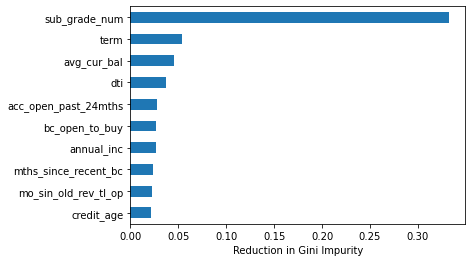

In [352]:
importances = model_dt.named_steps['decisiontreeclassifier'].feature_importances_
features = model_dt.named_steps['ordinalencoder'].get_feature_names()
feat_imp = pd.Series(importances,index=features).sort_values()
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('Reduction in Gini Impurity')

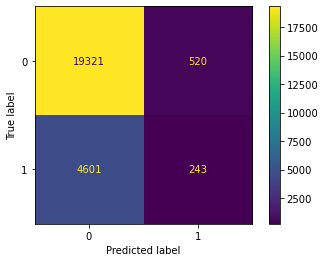

In [291]:
plot_confusion_matrix(model_dt, X_val, y_val)

In [340]:
estimators = np.arange(10, 300, 10)
train_acc_est = []
val_acc_est = []


for estimator in estimators:
    model_rf = make_pipeline(OneHotEncoder(),
                        StandardScaler(),
                        SimpleImputer(strategy = 'mean'),
                        RandomForestClassifier(random_state = 42,
                                              n_jobs = -1, 
                                              max_depth = 11,
                                              n_estimators = estimator))
    model_rf.fit(X_train, y_train)
    train_acc_est.append(model_rf.score(X_train, y_train))
    val_acc_est.append(model_rf.score(X_val, y_val))

In [341]:
pd.DataFrame(list(zip(train_acc_est, val_acc_est)), index = estimators, 
            columns = ['Training Accuracy', 'Validation Accuracy'])

,Training Accuracy,Validation Accuracy
10,0.836178,0.803686
20,0.834055,0.804294
30,0.833708,0.803970
40,0.833505,0.804051
50,0.832840,0.803970
60,0.833013,0.804092
70,0.833042,0.804011
80,0.833071,0.803970
90,0.833062,0.804092
100,0.832975,0.804092


In [338]:
depths = np.arange(1, 20, 1)
train_acc_depth = []
val_acc_depth = []
for depth in depths:
    model = make_pipeline(OneHotEncoder(),
                        StandardScaler(),
                        SimpleImputer(strategy = 'mean'),
                        RandomForestClassifier(random_state = 42,
                                              n_jobs = -1,
                                              max_depth = depth))
    model.fit(X_train, y_train)
    train_acc_depth.append(model.score(X_train, y_train))
    val_acc_depth.append(model.score(X_val, y_val))

In [339]:
pd.DataFrame(list(zip(train_acc_depth, val_acc_depth)), index = depths, 
            columns = ['Training Accuracy', 'Validation Accuracy'])

,Training Accuracy,Validation Accuracy
1,0.829878,0.803767
2,0.829878,0.803767
3,0.829878,0.803767
4,0.829878,0.803767
5,0.829878,0.803767
6,0.829878,0.803767
7,0.829878,0.803767
8,0.829945,0.803767
9,0.830360,0.803808
10,0.831441,0.803848


In [345]:
samples = np.arange(0.1, 1, 0.05)
train_err_samp = []
val_err_samp = []

for sample in samples:
    model = make_pipeline(OneHotEncoder(),
                        StandardScaler(),
                        SimpleImputer(strategy = 'mean'),
                        RandomForestClassifier(random_state = 42,
                                               n_jobs = -1,
                                               n_estimators = 20,
                                               max_depth = 11,
                                               max_samples = sample))
    model.fit(X_train, y_train)
    train_err_samp.append(model.score(X_train, y_train))
    val_err_samp.append(model.score(X_val, y_val))

In [346]:
pd.DataFrame(list(zip(train_err_samp, val_err_samp)), index = samples,
            columns = ['Training Error', 'Validation Error'])

,Training Error,Validation Error
0.10,0.832097,0.803241
0.15,0.832116,0.804173
0.20,0.832049,0.804173
0.25,0.833139,0.803160
0.30,0.832647,0.804051
0.35,0.833332,0.803443
0.40,0.832811,0.803848
0.45,0.832280,0.803403
0.50,0.833448,0.804011
0.55,0.833515,0.804416


In [347]:
model_rf = make_pipeline(OneHotEncoder(),
                        StandardScaler(),
                        SimpleImputer(strategy = 'mean'),
                        RandomForestClassifier(random_state = 42,
                                              n_jobs = -1,
                                              max_depth = 11,
                                              max_samples = 0.65,
                                              n_estimators = 20))
model_rf.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['home_ownership', 'verification_status',
                                     'purpose'])),
                ('standardscaler', StandardScaler()),
                ('simpleimputer', SimpleImputer()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=11, max_samples=0.65,
                                        n_estimators=20, n_jobs=-1,
                                        random_state=42))])

In [348]:
print(f'Training Score is {model_rf.score(X_train, y_train)}.')
print(f'Validation Score is {model_rf.score(X_val, y_val)}.')

Training Score is 0.8342289843606788.
Validation Score is 0.8040105327121734.


Text(0.5, 0, 'Reduction in Gini Impurity')

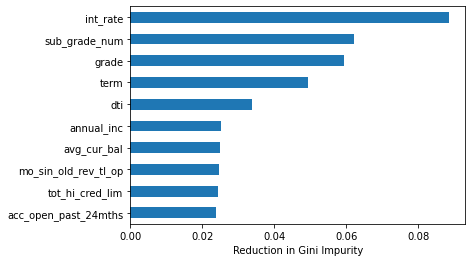

In [351]:
importances = model_rf.named_steps['randomforestclassifier'].feature_importances_
features = model_rf.named_steps['onehotencoder'].get_feature_names()
feat_imp = pd.Series(importances,index=features).sort_values()
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('Reduction in Gini Impurity')

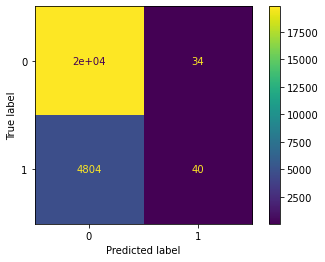

In [350]:
plot_confusion_matrix(model_rf, X_val, y_val)

In [293]:
model_logr = make_pipeline(OrdinalEncoder(),
                        StandardScaler(),
                        SimpleImputer(strategy = 'mean'),
                        LogisticRegression(random_state = 42,
                                          n_jobs = -1,
                                          ) )

In [294]:
model_logr.fit(X_train, y_train)
print(f'Training Score is {model_logr.score(X_train, y_train)}.')
print(f'Validation Score is {model_logr.score(X_val, y_val)}.')

Training Score is 0.8308811469478722.
Validation Score is 0.8036054283978125.


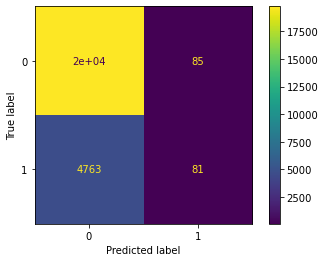

In [407]:
plot_confusion_matrix(model_logr, X_val, y_val)

In [298]:
df.head()

,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,credit_age,sub_grade_num
issue_d,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2007-07-01,3500.0,1,10.28,113.39,2,NaN,RENT,20000.0,Not Verified,moving,1.50,0.0,684.0,0.0,17.0,0.0,1882.0,32.4,18.0,0,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,1399.0,28
2007-07-01,5000.0,1,7.43,155.38,4,7.0,MORTGAGE,95000.0,Not Verified,vacation,3.83,0.0,774.0,0.0,8.0,0.0,3660.0,6.8,16.0,0,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2556.0,46
2007-07-01,5000.0,1,7.43,155.38,4,8.0,MORTGAGE,150000.0,Not Verified,home_improvement,0.00,0.0,779.0,0.0,2.0,0.0,6053.0,19.5,19.0,0,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7152.0,46
2007-07-01,3000.0,1,10.28,97.20,2,2.0,MORTGAGE,200000.0,Not Verified,home_improvement,0.00,1.0,679.0,0.0,5.0,0.0,0.0,0.0,8.0,0,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3802.0,28
2007-08-01,4000.0,1,7.75,124.89,4,1.0,OWN,61800.0,Not Verified,other,3.46,0.0,749.0,0.0,12.0,0.0,1918.0,17.1,16.0,0,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,2525.0,44


In [376]:
data = df.drop(columns = 'loan_status') #sub_grade_num, grade
target = 'int_rate'
y2 = data[target]
X2 = data.drop(columns = target).copy()

In [377]:
cutoff = '2017-01-01'
mask = X2.index < cutoff
X2_train, y2_train = X2[mask], y2[mask]
X2_val, y2_val = X2[~mask], y2[~mask]

print(f'The shape of the training data is {X2_train.shape} for X and {y2_train.shape} for y.')
print(f'The shape of the validation data is {X2_val.shape} for X and {y2_val.shape} for y.')

The shape of the training data is (103649, 61) for X and (103649,) for y.
The shape of the validation data is (24685, 61) for X and (24685,) for y.


In [378]:
baseline_reg = [y2_train.mean()]*len(y2_train)
print('Baseline MAE', mean_absolute_error(y2_train,baseline_reg))

Baseline MAE 2.980879659397058


In [379]:
linear_data = data.drop(columns = 'verification_status') #sub_grade_num, grade
target = 'int_rate'
y_linear = linear_data[target]
X_linear = linear_data.drop(columns = target).copy()
cutoff = '2017-01-01'
mask = X_linear.index < cutoff
X_linear_train, y_linear_train = X_linear[mask], y_linear[mask]
X_linear_val, y_linear_val = X_linear[~mask], y_linear[~mask]

print(f'The shape of the training data is {X_linear_train.shape} for X and {y_linear_train.shape} for y.')
print(f'The shape of the validation data is {X_linear_val.shape} for X and {y_linear_val.shape} for y.')

The shape of the training data is (103649, 60) for X and (103649,) for y.
The shape of the validation data is (24685, 60) for X and (24685,) for y.


In [380]:
model_linear = make_pipeline(OneHotEncoder(use_cat_names = True),
                            StandardScaler(),
                            SimpleImputer(strategy = 'mean'),
                            LinearRegression(n_jobs = -1))

In [383]:
model_linear.fit(X_linear_train, y_linear_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['home_ownership', 'purpose'],
                               use_cat_names=True)),
                ('standardscaler', StandardScaler()),
                ('simpleimputer', SimpleImputer()),
                ('linearregression', LinearRegression(n_jobs=-1))])

In [385]:
model_linear.fit(X_linear_train, y_linear_train)
print('Training MAE', mean_absolute_error(y_linear_train,model_linear.predict(X_linear_train)))
print('Validation MAE', mean_absolute_error(y_linear_val,model_linear.predict(X_linear_val)))
print('Validation R2', model_linear.score(X_linear_val,y_linear_val))

Training MAE 0.5846234004370967
Validation MAE 0.6237424831228068
Validation R2 0.9518898004533076


In [386]:
importances = model_linear.named_steps['linearregression'].coef_
features = model_linear.named_steps['onehotencoder'].get_feature_names()
feat_imp = pd.Series(importances,index=features).sort_values()

<AxesSubplot:>

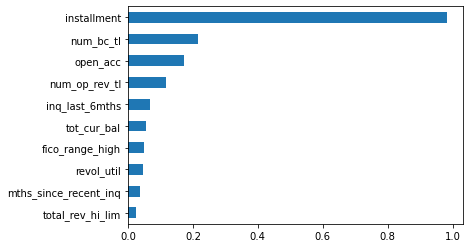

In [387]:
feat_imp.tail(10).plot(kind='barh')

In [325]:
alphas = np.arange(1, 211, 10)
train_acc_ridge = []
val_acc_ridge = []
for a in alphas:
    model = make_pipeline(OneHotEncoder(use_cat_names = True),
                            StandardScaler(),
                            SimpleImputer(strategy = 'mean'),
                            Ridge(alpha = a))
    model.fit(X2_train, y2_train)
    train_acc_ridge.append(mean_absolute_error(y2_train, model.predict(X2_train)))
    val_acc_ridge.append(mean_absolute_error(y2_val, model.predict(X2_val)))

In [326]:
pd.DataFrame(list(zip(train_acc_ridge, val_acc_ridge)), index = alphas, 
             columns = ['Training Accuracy', 'Validation Accuracy'])

,Training Accuracy,Validation Accuracy
1,0.580738,0.629479
11,0.580716,0.629385
21,0.580696,0.629297
31,0.580679,0.629212
41,0.580665,0.629133
51,0.580653,0.629058
61,0.580645,0.628987
71,0.580640,0.628920
81,0.580638,0.628857
91,0.580638,0.628797


In [327]:
model_ridge = make_pipeline(OneHotEncoder(use_cat_names = True),
                            StandardScaler(),
                            SimpleImputer(strategy = 'mean'),
                            Ridge(alpha = 200))
model_ridge.fit(X2_train, y2_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['home_ownership', 'verification_status',
                                     'purpose'],
                               use_cat_names=True)),
                ('standardscaler', StandardScaler()),
                ('simpleimputer', SimpleImputer()),
                ('ridge', Ridge(alpha=200))])

In [328]:
print('Training MAE', mean_absolute_error(y2_train,model_ridge.predict(X2_train)))
print('Validation MAE', mean_absolute_error(y2_val,model_ridge.predict(X2_val)))
print('Validation R2', model_ridge.score(X2_val,y2_val))

Training MAE 0.5807735107612173
Validation MAE 0.6283902247557921
Validation R2 0.9508109645955071


<AxesSubplot:>

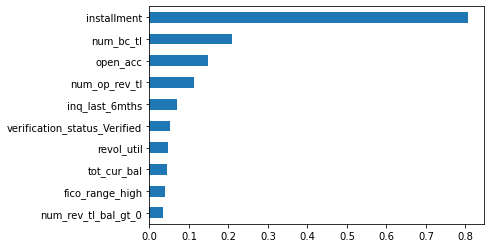

In [329]:
importances = model_ridge.named_steps['ridge'].coef_
features = model_ridge.named_steps['onehotencoder'].get_feature_names()
feat_imp = pd.Series(importances,index=features).sort_values()
feat_imp.tail(10).plot(kind='barh')

<AxesSubplot:>

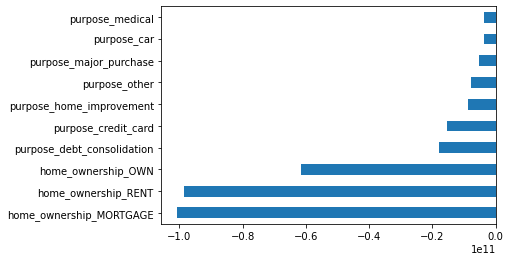

In [388]:
feat_imp.head(10).plot(kind='barh')

In [390]:
dtr_train_acc_depth = []
dtr_val_acc_depth = []
for depth in depths:
    model = make_pipeline(OneHotEncoder(use_cat_names = True),
                                StandardScaler(),
                                SimpleImputer(strategy = 'mean'),
                                DecisionTreeRegressor(random_state = 42,
                                                     max_depth = depth))
    model.fit(X2_train, y2_train)
    dtr_train_acc_depth.append(mean_absolute_error(y2_train, model.predict(X2_train)))
    dtr_val_acc_depth.append(mean_absolute_error(y2_val, model.predict(X2_val)))

In [391]:
pd.DataFrame(list(zip(dtr_train_acc_depth, dtr_val_acc_depth)), index = depths, 
            columns = ['Training Accuracy', 'Validation Accuracy'])

,Training Accuracy,Validation Accuracy
1,1.801336,1.953992
2,0.986316,1.054245
3,0.734247,0.742831
4,0.640969,0.603238
5,0.601464,0.581720
6,0.584384,0.603068
7,0.566096,0.604537
8,0.551791,0.604634
9,0.536889,0.608125
10,0.518677,0.610741


In [395]:
model_dtr = make_pipeline(OneHotEncoder(use_cat_names = True),
                                StandardScaler(),
                                SimpleImputer(strategy = 'mean'),
                                DecisionTreeRegressor(random_state = 42,
                                                     max_depth = 5))

In [396]:
model_dtr.fit(X2_train, y2_train)
print(f'Training MAE is {mean_absolute_error(y2_train, model_dtr.predict(X2_train))}.')
print(f'Validation MAE is {mean_absolute_error(y2_val, model_dtr.predict(X2_val))}.')

Training MAE is 0.6014635020925977.
Validation MAE is 0.5817198288440972.


<AxesSubplot:>

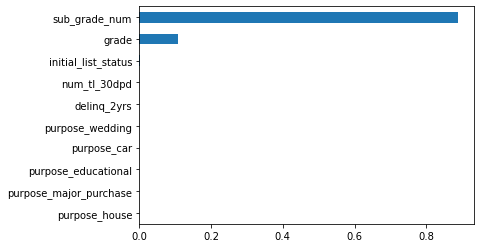

In [397]:
importances = model_dtr.named_steps['decisiontreeregressor'].feature_importances_
features = model_dtr.named_steps['onehotencoder'].get_feature_names()
feat_imp = pd.Series(importances,index=features).sort_values()
feat_imp.tail(10).plot(kind='barh')

In [398]:
data3 = data.drop(columns = ['sub_grade_num', 'grade'])
target = 'int_rate'
y3 = data3[target]
X3 = data3.drop(columns = target).copy()
cutoff = '2017-01-01'
mask = X3.index < cutoff
X3_train, y3_train = X3[mask], y3[mask]
X3_val, y3_val = X3[~mask], y3[~mask]

print(f'The shape of the training data is {X3_train.shape} for X and {y3_train.shape} for y.')
print(f'The shape of the validation data is {X3_val.shape} for X and {y3_val.shape} for y.')

The shape of the training data is (103649, 59) for X and (103649,) for y.
The shape of the validation data is (24685, 59) for X and (24685,) for y.


In [399]:
model_dtr2 = make_pipeline(OneHotEncoder(use_cat_names = True),
                                StandardScaler(),
                                SimpleImputer(strategy = 'mean'),
                                DecisionTreeRegressor(random_state = 42,
                                                     max_depth = 5))

In [404]:
model_dtr2.fit(X3_train, y3_train)
print(f'Training MAE is {mean_absolute_error(y3_train, model_dtr2.predict(X3_train))}.')
print(f'Validation MAE is {mean_absolute_error(y3_val, model_dtr2.predict(X3_val))}.')

Training MAE is 2.3083523473453753.
Validation MAE is 2.6930223881840285.


<AxesSubplot:>

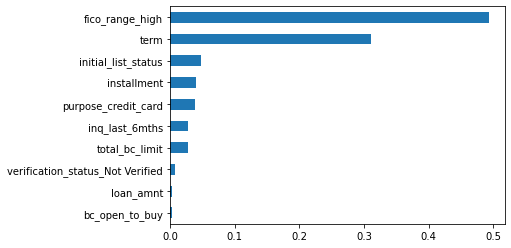

In [405]:
importances = model_dtr2.named_steps['decisiontreeregressor'].feature_importances_
features = model_dtr2.named_steps['onehotencoder'].get_feature_names()
feat_imp = pd.Series(importances,index=features).sort_values()
feat_imp.tail(10).plot(kind='barh')

In [ ]:
for estimator in estimators: